<a href="https://colab.research.google.com/github/Suratan63011017/DataStructures-And-Algorithm-Grader/blob/main/deeplab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import imageio
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


import os
import shutil
from PIL import Image
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
directory = '/content/drive/MyDrive/imageproject'

zip_file_path = '/content/drive/MyDrive/imageproject/data.zip'

all_files = os.listdir(directory)

for filename in all_files:
    file_path = os.path.join(directory, filename)

    if file_path != zip_file_path:
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

print("Files deleted except for:", zip_file_path)

Files deleted except for: /content/drive/MyDrive/imageproject/data.zip


In [4]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(directory)

print("Zip file extracted successfully.")

Zip file extracted successfully.


In [5]:
image_path = ["/content/drive/MyDrive/imageproject/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["/content/drive/MyDrive/imageproject/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [6]:
# image_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
# mask_path = ["../input/lyft-udacity-challenge/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [7]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

In [8]:
image_paths = list_image_paths(image_path)
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")

1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 /content/drive/MyDrive/imageproject/dataA/dataA/CameraRGB/02_00_000.png
3. An example of a mask path is: 
 /content/drive/MyDrive/imageproject/dataA/dataA/CameraSeg/02_00_000.png


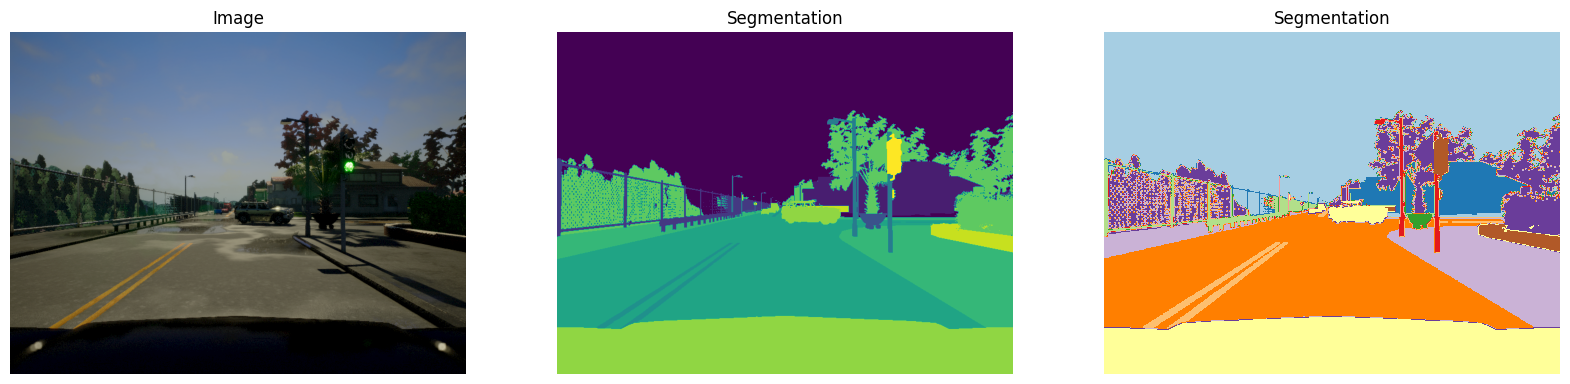

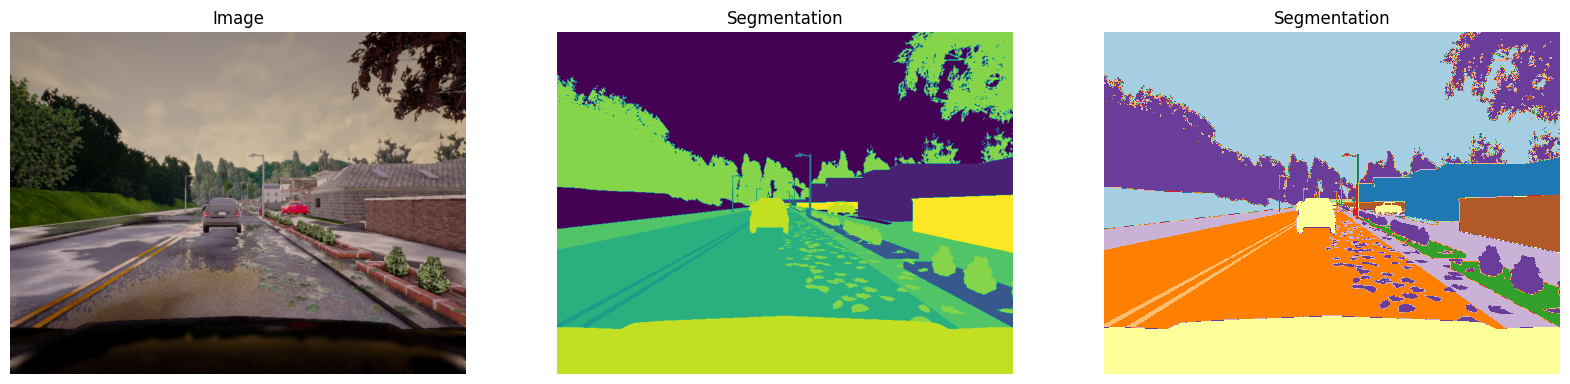

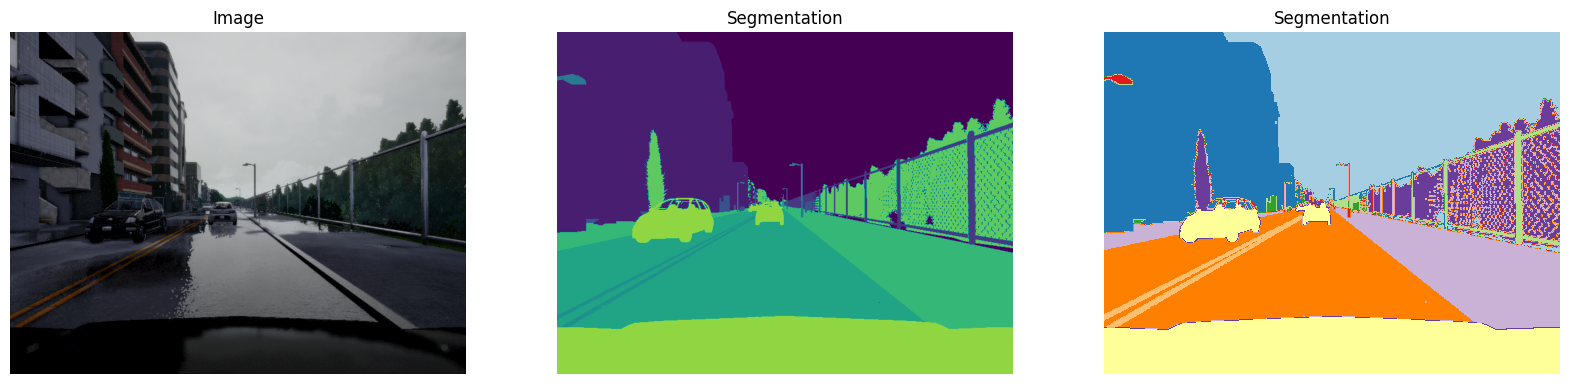

In [9]:
import random
number_of_samples = len(image_paths)

for i in range(3):
    N = random.randint(0, number_of_samples - 1)

    img = imageio.imread(image_paths[N])
    mask = imageio.imread(mask_paths[N])
    mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(img)
    arr[0].set_title('Image')
    arr[0].axis("off")
    arr[1].imshow(mask)
    arr[1].set_title('Segmentation')
    arr[1].axis("off")
    arr[2].imshow(mask, cmap='Paired')
    arr[2].set_title('Segmentation')
    arr[2].axis("off")

In [10]:
# First split the image paths into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, train_size=0.9, random_state=0)

# Keep part of the validation set as test set
validation_image_paths, test_image_paths, validation_mask_paths, test_mask_paths = train_test_split(val_image_paths, val_mask_paths, train_size = 0.50, random_state=0)

print(f'There are {len(train_image_paths)} images in the Training Set')
print(f'There are {len(validation_image_paths)} images in the Validation Set')
print(f'There are {len(test_image_paths)} images in the Test Set')

There are 4500 images in the Training Set
There are 250 images in the Validation Set
There are 250 images in the Test Set


In [11]:
!pip install tensorflow-addons

In [12]:
import tensorflow_addons as tfa
import math

In [13]:
def read_image(image_path, mask_path):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (256, 256), method='nearest')

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (256, 256), method='nearest')

    # random_rotate = random.randint(0, 30)
    # image = tfa.image.rotate(image, random_rotate * math.pi / 180)
    # mask = tfa.image.rotate(mask, random_rotate * math.pi / 180)

    # random_flip = random.randint(0, 1)
    # if random_flip == 1:
    #   image = tf.image.flip_left_right(image)
    #   mask = tf.image.flip_left_right( mask)
    return image, mask

In [14]:
def data_generator(image_paths, mask_paths, buffer_size, batch_size):

    image_list = tf.constant(image_paths)
    mask_list = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().shuffle(buffer_size).batch(batch_size)

    return dataset

In [15]:
batch_size = 32
buffer_size = 500

train_dataset = data_generator(train_image_paths, train_mask_paths, buffer_size, batch_size)
validation_dataset = data_generator(validation_image_paths, validation_mask_paths, buffer_size, batch_size)
test_dataset = data_generator(test_image_paths, test_mask_paths, buffer_size, batch_size)

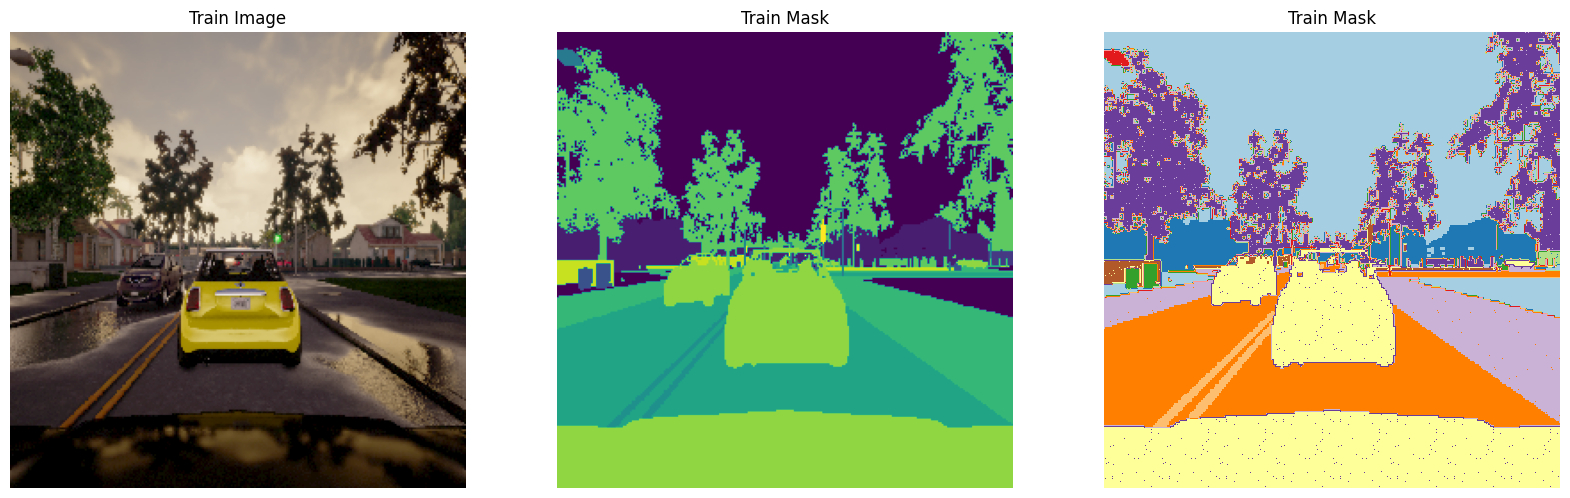

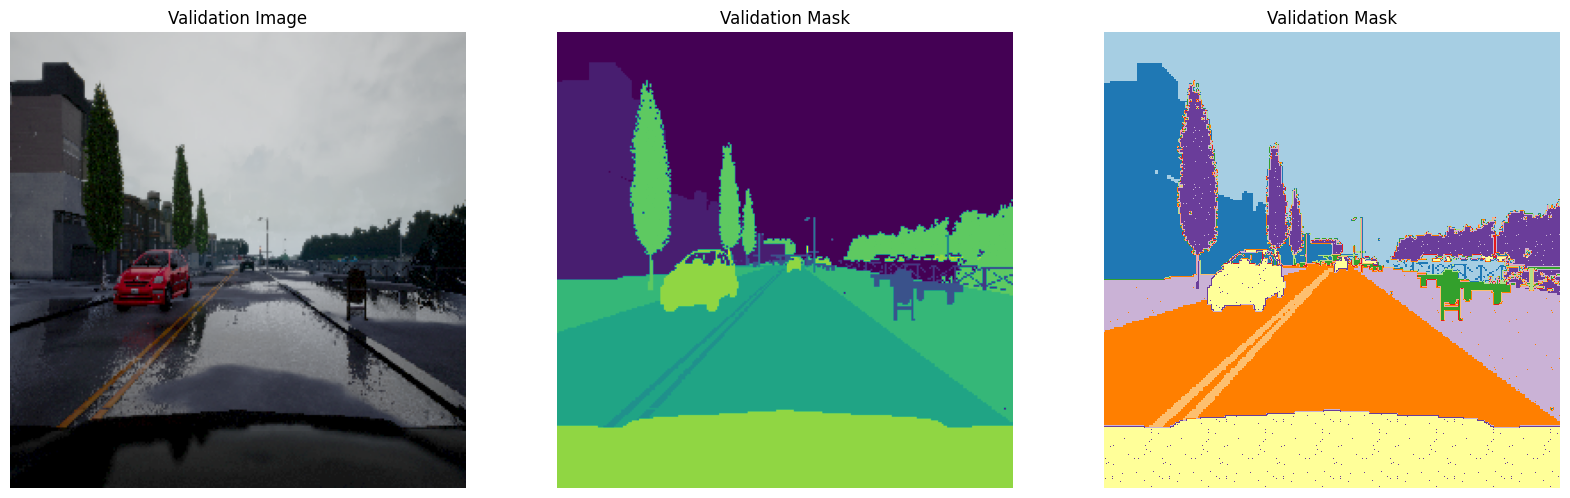

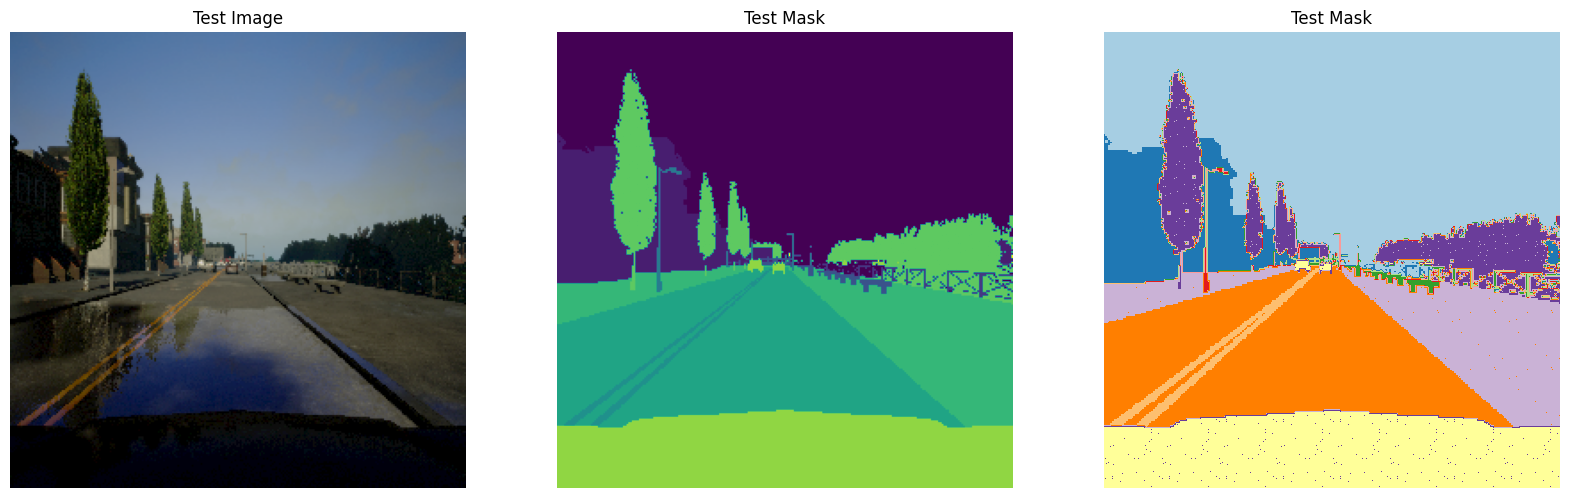

In [16]:
# Take a batch (32 images and their labelled segmentations from each category of data)
for train_images, train_masks in train_dataset:
    break
for validation_images, validation_masks in validation_dataset:
    break
for test_images, test_masks in test_dataset:
    break


for i in range(3):
    N = random.randint(0, batch_size-1)

    images = [train_images[N], validation_images[N], test_images[N]]
    masks = [train_masks[N], validation_masks[N], test_masks[N]]
    title = ['Train Image', 'Validation Image', 'Test Image', 'Train Mask', 'Validation Mask', 'Test Mask']

    fig, arr = plt.subplots(1, 3, figsize=(20, 8))
    arr[0].imshow(images[i])
    arr[0].set_title(title[i])
    arr[0].axis("off")
    arr[1].imshow(masks[i])
    arr[1].set_title(title[i+3])
    arr[1].axis("off")
    arr[2].imshow(masks[i], cmap='Paired')
    arr[2].set_title(title[i+3])
    arr[2].axis("off")

In [17]:
def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
        )(block_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [18]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [19]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    model = tf.keras.Model(inputs=model_input, outputs=model_output)

    return model

In [20]:
img_height = 256
img_width = 256
num_channels = 3
filters = 32
n_classes = 23

model = DeeplabV3(img_height, num_classes=23)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [21]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)
batch_size = 16
epochs = 50

In [22]:
history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = epochs,
                    verbose=1,
                    callbacks = [callback],
                    batch_size = batch_size,
                    shuffle = True)

Epoch 1/50
141/141 [==============================] - 65s 186ms/step - loss: 1.6737 - accuracy: 0.6654 - val_loss: 4.5241 - val_accuracy: 0.3354
Epoch 2/50
141/141 [==============================] - 18s 130ms/step - loss: 0.7397 - accuracy: 0.7315 - val_loss: 3.5551 - val_accuracy: 0.5612
Epoch 3/50
141/141 [==============================] - 18s 130ms/step - loss: 0.5824 - accuracy: 0.7887 - val_loss: 2.9642 - val_accuracy: 0.6084
Epoch 4/50
141/141 [==============================] - 18s 129ms/step - loss: 0.4748 - accuracy: 0.8482 - val_loss: 1.9357 - val_accuracy: 0.7045
Epoch 5/50
141/141 [==============================] - 18s 130ms/step - loss: 0.4032 - accuracy: 0.8742 - val_loss: 1.1146 - val_accuracy: 0.7768
Epoch 6/50
141/141 [==============================] - 18s 129ms/step - loss: 0.4294 - accuracy: 0.8605 - val_loss: 1.5392 - val_accuracy: 0.7908
Epoch 7/50
141/141 [==============================] - 18s 129ms/step - loss: 0.4338 - accuracy: 0.8517 - val_loss: 0.4240 - val_ac

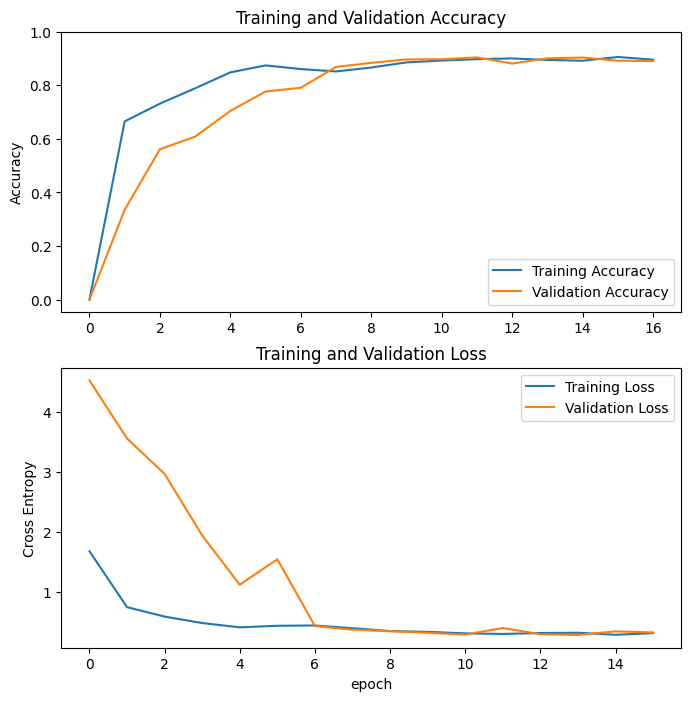

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
model.save('deeplabv3.h5')

In [25]:
train_loss, train_accuracy = model.evaluate(train_dataset, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(validation_dataset, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_dataset, batch_size = 32)

8/8 [==============================] - 0s 43ms/step - loss: 0.2875 - accuracy: 0.9054


In [26]:
print(f'Model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
print(f'Model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')

Model Accuracy on the Training Dataset: 90.35%
Model Accuracy on the Validation Dataset: 90.41%
Model Accuracy on the Test Dataset: 90.54%


In [27]:
def iou_score(dataset):

    """
    Argument:
        dataset -- the dataset to calculate IoU on

    Returns:
        min_iou -- minimum IoU
        max_iou -- maximum IoU
        mean_iou -- mean IoU ()
        """
    # Create empty lists
    intersections, unions, max_ious, min_ious = [], [], [], []

    for images, masks in dataset:
        pred_mask = model.predict(images)
        intersection = np.logical_and(masks, pred_mask)
        union = np.logical_or(masks, pred_mask)
        intersection_sum = np.array([np.sum(inter) for inter in intersection])
        union_sum = np.array([np.sum(un) for un in union])
        batch_iou_score = intersection_sum / union_sum
        batch_min_iou = np.amin(batch_iou_score)
        batch_max_iou = np.amax(batch_iou_score)

        intersections.append(np.sum(intersection))
        unions.append(np.sum(union))
        min_ious.append(batch_min_iou)
        max_ious.append(batch_max_iou)

    min_iou = np.amin(min_ious)
    max_iou = np.amax(max_ious)
    mean_iou = np.sum(intersections) / np.sum(unions)

    return min_iou, max_iou, mean_iou

In [28]:
train_min_iou, train_max_iou, train_mean_iou = iou_score(train_dataset)
validation_min_iou, validation_max_iou, validation_mean_iou = iou_score(validation_dataset)
test_min_iou, test_max_iou, test_mean_iou = iou_score(test_dataset)

1/1 [==============================] - 0s 33ms/step


In [29]:
print(f'IoU on the Training Dataset: \n Minimum IoU Score: {round(train_min_iou*100, 2)}% \n Maximum IoU Score: {round(train_max_iou*100, 2)}% \n Mean IoU Score: {round(train_mean_iou*100, 2)}% \n')
print(f'IoU on the Validation Dataset: \n Minimum IoU Score: {round(validation_min_iou*100, 2)}% \n Maximum IoU Score: {round(validation_max_iou*100, 2)}% \n Mean Iou Score: {round(validation_mean_iou*100, 2)}% \n')
print(f'IoU on the Test Dataset: \n Minimum IoU Score: {round(test_min_iou*100, 2)}% \n Maximum IoU Score: {round(test_max_iou*100, 2)}% \n Mean IoU Score: {round(test_mean_iou*100, 2)}% \n')

IoU on the Training Dataset: 
 Minimum IoU Score: 51.98% 
 Maximum IoU Score: 84.92% 
 Mean IoU Score: 68.93% 

IoU on the Validation Dataset: 
 Minimum IoU Score: 57.55% 
 Maximum IoU Score: 84.23% 
 Mean Iou Score: 68.95% 

IoU on the Test Dataset: 
 Minimum IoU Score: 52.46% 
 Maximum IoU Score: 84.4% 
 Mean IoU Score: 68.26% 



In [30]:
# Load model
from tensorflow.keras.models import Model, load_model
model = load_model('deeplabv3.h5')

In [31]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [32]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [33]:
def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 928ms/step


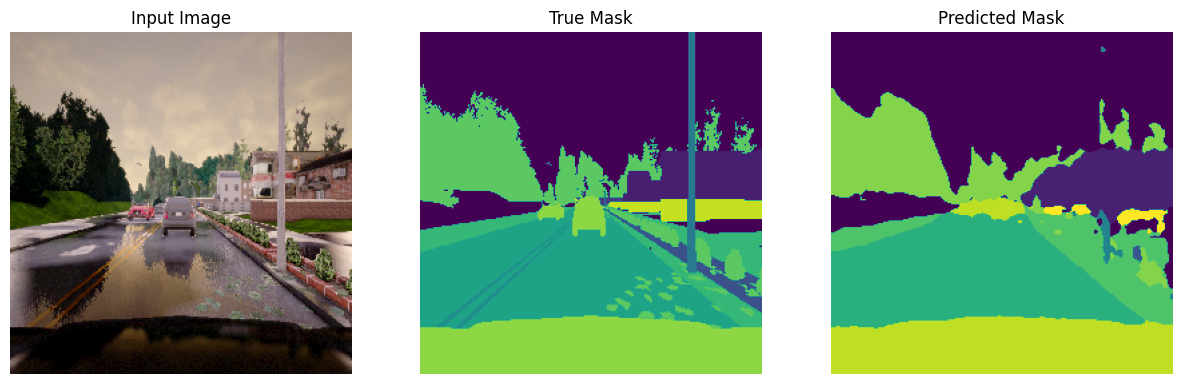

1/1 [==============================] - 0s 36ms/step


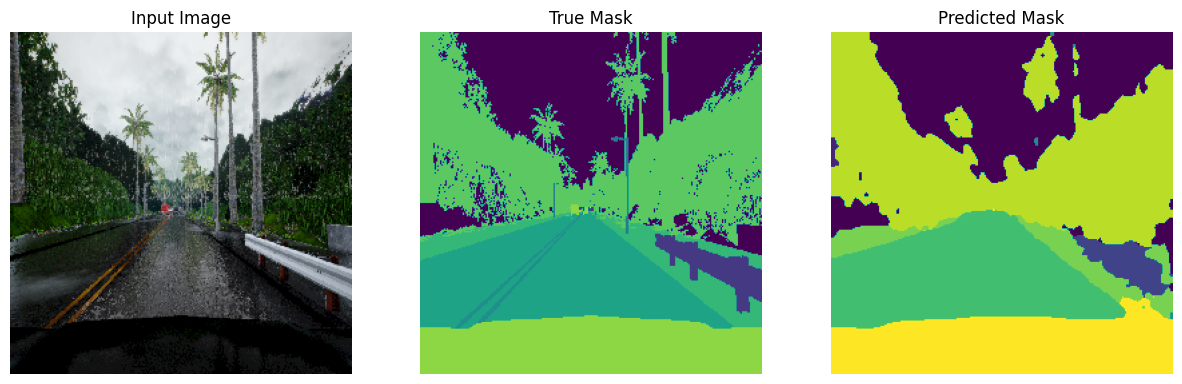

1/1 [==============================] - 0s 39ms/step


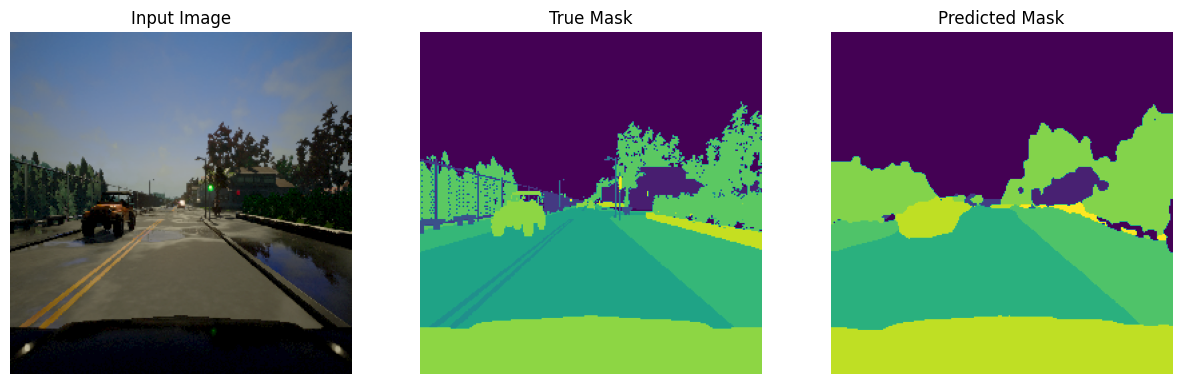

1/1 [==============================] - 0s 33ms/step


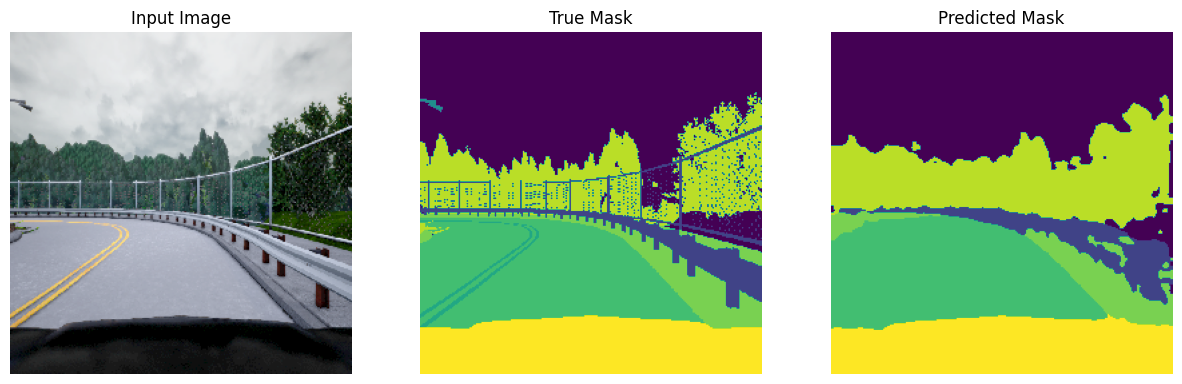

1/1 [==============================] - 0s 37ms/step


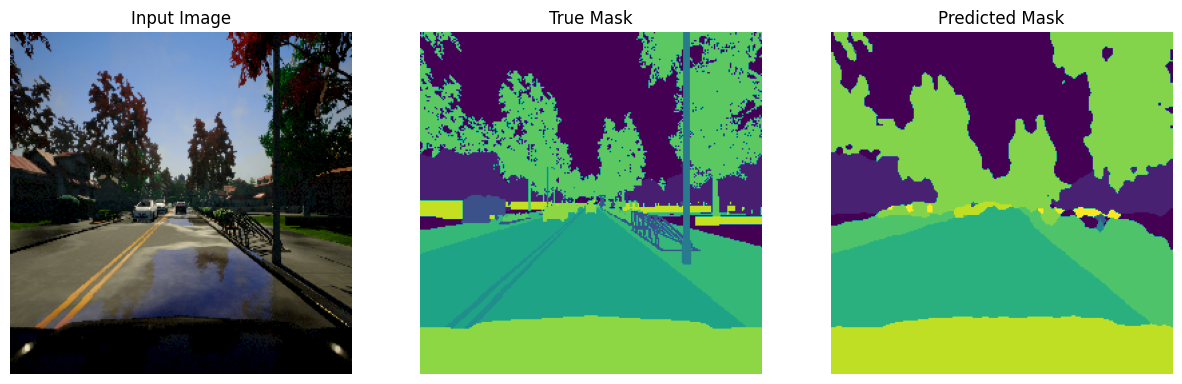

1/1 [==============================] - 0s 36ms/step


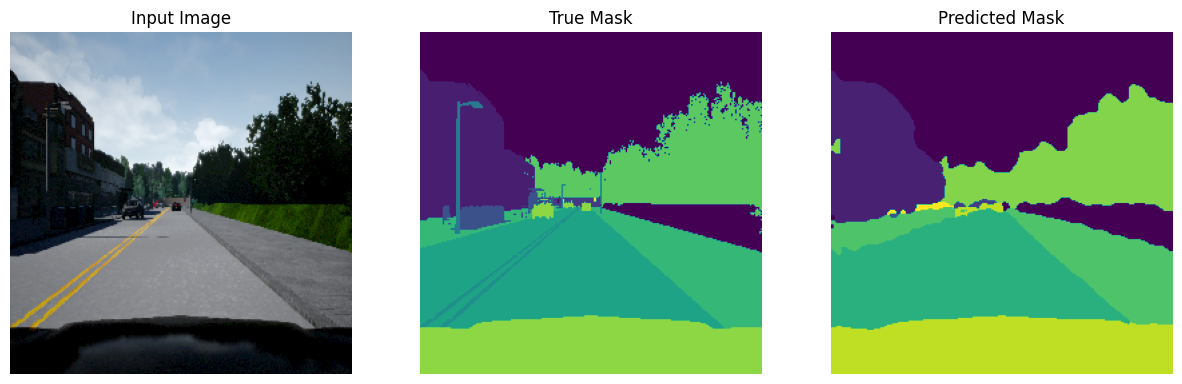

In [34]:
show_predictions(train_dataset, 6)

1/1 [==============================] - 0s 35ms/step


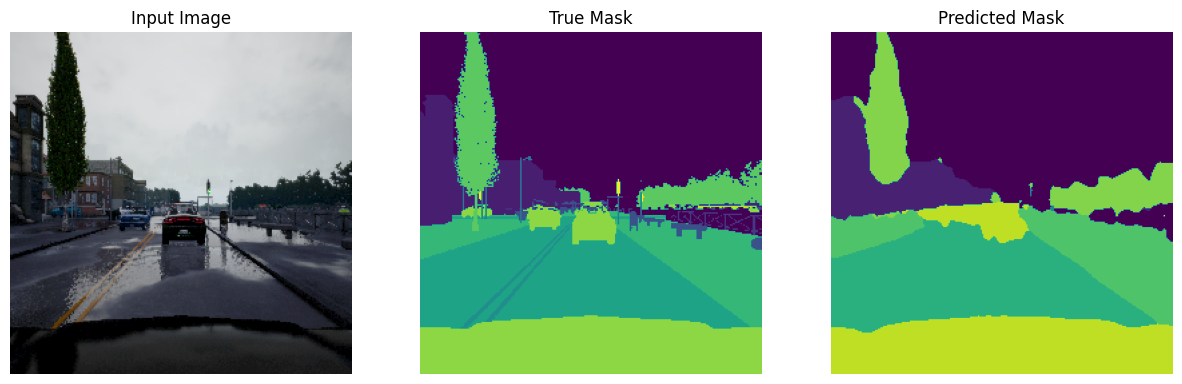

1/1 [==============================] - 0s 35ms/step


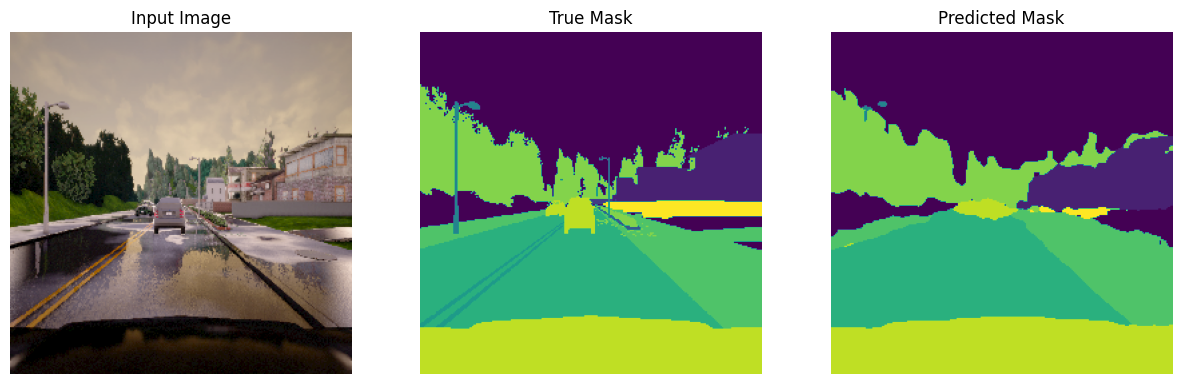

1/1 [==============================] - 0s 34ms/step


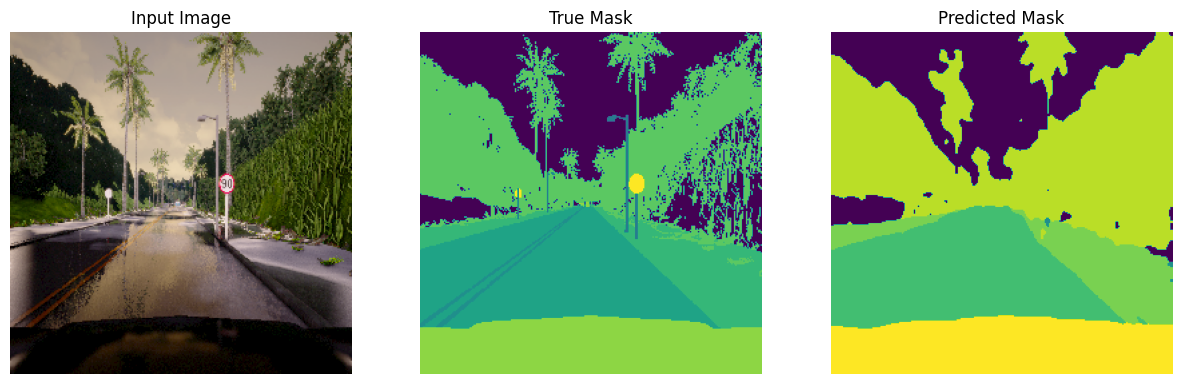

1/1 [==============================] - 0s 36ms/step


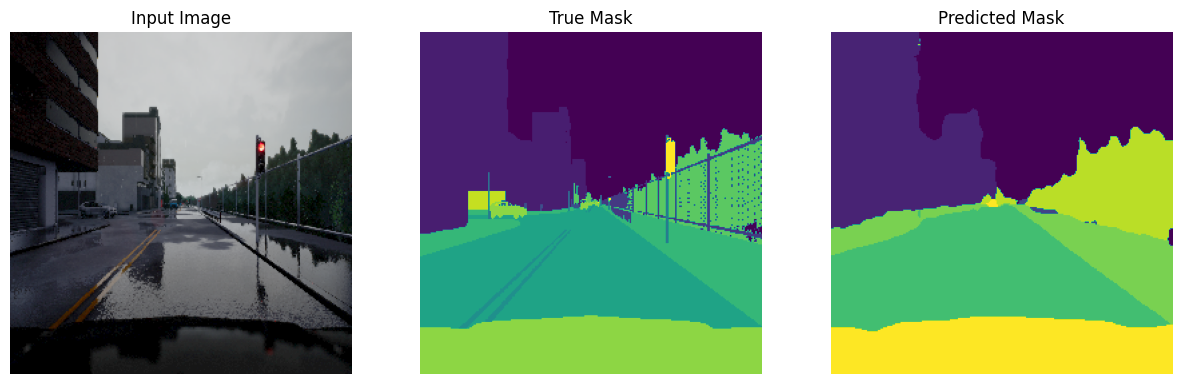

1/1 [==============================] - 0s 33ms/step


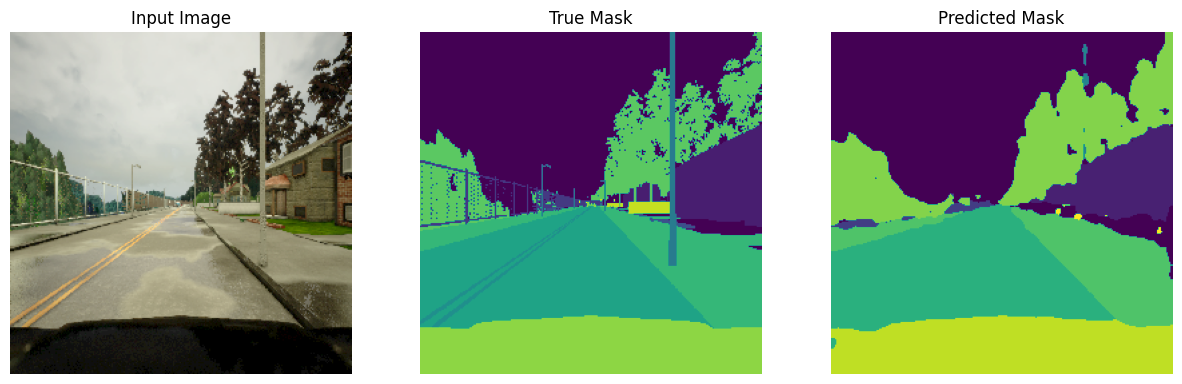

1/1 [==============================] - 0s 35ms/step


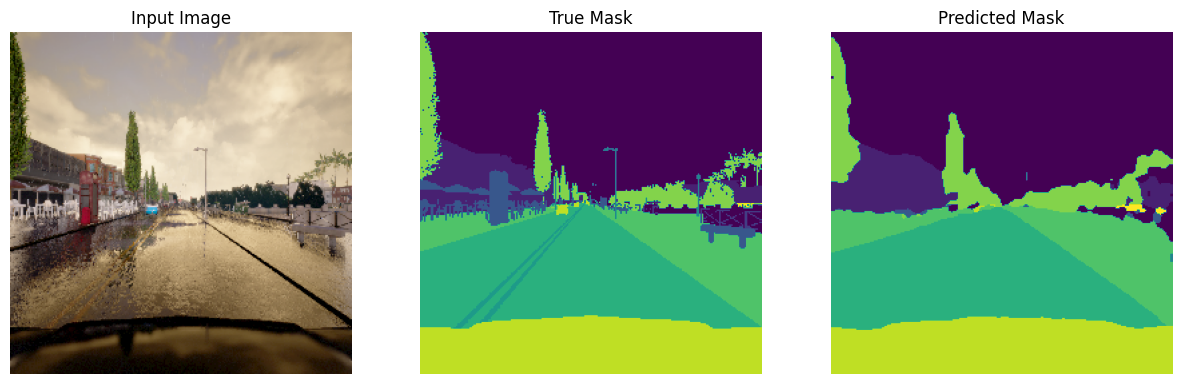

In [35]:
show_predictions(test_dataset, 6)